# FITC

## What is the Fully Independent Training Conditional (FITC aka SPGP)?

The Sparse Pseudo-input Guassian Process (SPGP) approximation is a particular method moodelling with a sparse, and therefore cheaply invertible, covariance matrix. This method discards the original GP model and works with a *new model*, which assumes the observed data are independent given certain *latent variables* called *pseudo-points*, leading to the sparse covariance structure. SPGP has also been called the Fully Independent Training Conditional (FITC) approximation and we adopt the same nomenclature because it's more appropriate and specific - there are in fact several sparse pseudo-input GP approximations, so SPGP is not very specific a name.

In any case, it's worth repeating that FITC works by throwing the original GP away and working with a computationally cheaper model which will hopefully approximate the predictions of the original. Let's start by laying out the modelling assumptions and the generative process and then moving on to inference and predictions.


## The FITC generative model and assumptions

Consider the following model. We define a set of $M$ inputs $\mathbf{\bar{X}} = \{\mathbf{\bar{x}}_m\}_{m=1}^M$, which we call the *inducing-* or *pseudo-points*. We also define a set of $M$ unobserved random variables $\mathbf{\bar{f}} = (\bar{f_1}, \bar{f_2}, ..., \bar{f_M})^\top$, and place a GP prior over them:

$$p\left(\mathbf{\bar{f}} | \mathbf{\bar{X}}\right) \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}\right).$$

Given the sampled $\mathbf{\bar{f}}$ as well as $N$ further inputs $\mathbf{X} = \{\mathbf{\bar{x}}_n\}_{n=1}^N$, we sample $N$ further random variables from the GP prior conditioned on $\mathbf{\bar{f}}$ *independently from each other*:

$$p \left(f_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{x}_n \right) \sim \mathcal{N}\left(f_n;~\mathbf{K}_{\mathbf{x}_n\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{\bar{f}},~\mathbf{K}_{\mathbf{x}_n\mathbf{x}_n} - \mathbf{K}_{\mathbf{x}_n\mathbf{X}}\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{K}_{\mathbf{X}\mathbf{x}_n} \right) \text{ independently for each } n.$$


Finally, some idependent and identically distributed onse is added to the $\mathbf{f}$ to obtain the noisy observations $\mathbf{y}$:

\begin{align}
p(\mathbf{y} | \mathbf{f}) = \mathcal{N}\left(\mathbf{y}; \mathbf{f}, \sigma^2 \mathbf{I}\right),
\end{align}

and that's how we obtain the observed data $\mathbf{y}$. Let sample some data accoding to this generative process and see what it looks like. We'll work with a zero-mean GP with an Exponentiated Quadratic covariance function - imports and definitions are hidden below.

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def eq_covariance(x1,
                  x2,
                  coeff,
                  scale,
                  diag_only=False,
                  epsilon=None):

    # If not calculating diagonal only, expand to broadcast
    if not diag_only:

        x1 = x1[:, None, :]
        x2 = x2[None, :, :]

    # Compute differences
    diffs = x1 - x2

    # Compute quadratic form
    quad = - 0.5 * diffs ** 2 / scale
    quad = np.sum(quad, axis=-1)

    # Exponentiate and multiply by covariance coeff
    exp_quad = np.exp(quad)
    eq_cov = coeff ** 2 * exp_quad

    # Add epsilon for invertibility
    if epsilon is not None:

        eq_cov = eq_cov + epsilon * np.eye(eq_cov.shape[0])

    return eq_cov

In [60]:
# Set random seed - change to see different samples
np.random.seed(1)

# Num. inducing points (M), num. observations (N)
M = 2
N = 100

# EQ hyperparameters
coeff = 1e0
scale = 1e0
noise = 1e-1

# Pick inducing and observed inputs at random
x_ind = np.random.uniform(low=-3., high=3., size=(M, 1))
x_obs = np.random.uniform(low=-4., high=4., size=(N, 1))

# Compute covariance matrix terms
K_ind_ind = eq_covariance(x_ind, x_ind, coeff, scale, epsilon=1e-12)
K_ind_obs = eq_covariance(x_ind, x_obs, coeff, scale)
K_obs_ind = eq_covariance(x_obs, x_ind, coeff, scale)
K_obs_diag = eq_covariance(x_obs, x_obs, coeff, scale, diag_only=True)

# Sample f_ind | x_ind
f_ind = np.dot(np.linalg.cholesky(K_ind_ind),
               np.random.normal(loc=0., scale=1., size=(M, 1)))

# Mean and vaariance of normal distribution of f_obs | f_ind
f_obs_mean = np.dot(K_obs_ind, np.linalg.solve(K_ind_ind, f_ind))
f_obs_var = K_obs_diag - np.diag(np.dot(K_obs_ind, np.linalg.solve(K_ind_ind, K_ind_obs)))
f_obs_var = f_obs_var[:, None]

# Sample f_obs | f_ind from normal i.i.d.
f_obs = np.random.normal(f_obs_mean, f_obs_var ** 0.5)

# Sample y_obs | f_obs (noisy observations)
y_obs = np.random.normal(loc=f_obs, scale=noise)

# Locations to plot mean and variance of generative model, y_plot | f_ind, x_plot
x_plot = np.linspace(-4., 4., 100)[:, None]

# Covariances between inducing points and input locations
K_ind_plot = eq_covariance(x_ind, x_plot, coeff, scale)
K_plot_ind = eq_covariance(x_plot, x_ind, coeff, scale)
K_plot_diag = eq_covariance(x_plot, x_plot, coeff, scale, diag_only=True)

# Mean and standard deviation of y_plot | f_ind, x_plot
y_plot_mean = np.dot(K_plot_ind, np.linalg.solve(K_ind_ind, f_ind))[:, 0]
f_plot_var = K_plot_diag - np.diag(np.dot(K_plot_ind, np.linalg.solve(K_ind_ind, K_ind_plot)))
y_plot_var = f_plot_var + noise ** 2
y_plot_std = y_plot_var ** 0.5

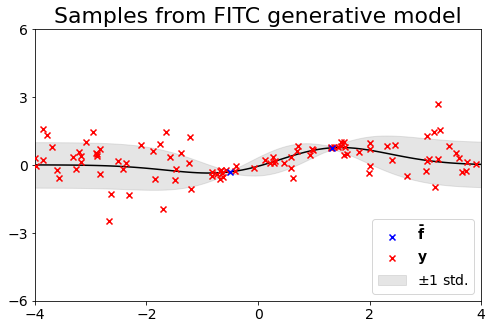

In [4]:
# Plot inducing points and observed data
plt.figure(figsize=(8, 5))

# Plot inducing points
plt.scatter(x_ind,
            f_ind,
            color='blue',
            marker='x',
            zorder=4,
            label=r'$\mathbf{\bar{f}}$')

# Plot observed data
plt.scatter(x_obs,
            y_obs,
            color='red',
            marker='x',
            zorder=3,
            label=r'$\mathbf{y}$')

# Plot mean of generative model
plt.plot(x_plot,
         y_plot_mean, color='black', 
         zorder=2)

# Plot noise of generative model
plt.fill_between(x_plot[:, 0],
                 y_plot_mean - y_plot_std,
                 y_plot_mean + y_plot_std,
                 color='gray',
                 zorder=1,
                 alpha=0.2,
                 label='$\pm 1$ std.')

# Plot formatting
plt.title('Samples from FITC generative model', fontsize=22)
plt.xticks(np.arange(-4, 5, 2), fontsize=14)
plt.yticks(np.arange(-6, 7, 3), fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.xlim([-4., 4.])
plt.show()

## Interpretation and comparison to the full GP

### Comparison to the full GP

So how is the FITC generative model different from a zero-mean GP with an EQ covariance? In the vanilla GP setting, all observations are correlated and the joint distribution does not factor. Suppose we drew $\mathbf{\bar{f}}$ from a GP prior:

$$\mathbf{\bar{f}} | \mathbf{\bar{X}} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}\right).$$

The way to draw $\mathbf{f}$ further samples *conditioned on* $\mathbf{\bar{f}}$ *under the vanilla GP model* is to use the conditional prior:

\begin{align}
p(\mathbf{f} | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X}) = \mathcal{N}\left(\mathbf{f} ;~\mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{\bar{f}},~\mathbf{K}_{\mathbf{X}\mathbf{X}} - \mathbf{K}_{\mathbf{X}\mathbf{X}}\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{K}_{\mathbf{X}\mathbf{X}} \right).
\end{align}

Since the matrix $\mathbf{K}_{\mathbf{X}\mathbf{X}} - \mathbf{K}_{\mathbf{X}\mathbf{X}}\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{K}_{\mathbf{X}\mathbf{X}}$ is in general full-rank, it includes correlations between all $f$'s and the joint over $\mathbf{f}$ cannot be simplified:

\begin{align}
p(\mathbf{f} | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X}) &= p(f_{n-1}, ..., f_{1}| f_n, \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})p(f_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})\\
&=p(f_{n-2}, ..., f_1| f_{n-1}, f_n, \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})p(f_{n-1} | f_n \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})p(f_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})\\
&...\\
&=p(f_1| f_2, ..., f_n, \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})~p(f_2| f_3, ..., f_n, \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})~...~p(f_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X}).
\end{align}

By contrast, the generative process of FITC says: given $\mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X}$, my $f_n$ samples will all be drawn from the conditional prior, but they will be drawn independently from each other. Under this generative process we have $p(f_i | f_j, \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})$ = $p(f_i |\mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})$ for $i \neq j$ and we can simplify the conditional prior as:

\begin{align}
p(\mathbf{f} | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X}) &= p(f_1, ..., f_{n-1}| f_n, \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})p(f_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})\\
&=p(f_1, ..., f_{n-2}| f_n, f_{n-1}, \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})p(f_{n-1} | f_n \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})p(f_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})\\
&...\\
&=p(f_1| \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X})~...~p(f_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X}).
\end{align}

It's worthwhile stressing that FITC is just a different model. It can be considered as an attempt to approximate the predictions made by a full GP, but its modelling assumption about independence makes is a fundamentally different model from the full GP.

### Interpretation as an input dependent noise regressor

Snelson and Ghahramani point out that FITC can be regarded as a regression model with an input-dependent noise level, since in the predictive posterior:

\begin{align}
p \left(y_n | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{x}_n \right) \sim \mathcal{N}\left(f_n;~\mathbf{K}_{\mathbf{x}_n\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{\bar{f}},~\mathbf{K}_{\mathbf{x}_n\mathbf{x}_n} - \mathbf{K}_{\mathbf{x}_n\mathbf{X}}\mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{K}_{\mathbf{X}\mathbf{x}_n} + \sigma^2 \mathbf{I} \right),
\end{align}

both the predictive variance is a function of $\mathbf{x}$. However, the FITC model couples the predictive mean and variance in a potentially undesirable way. In particular, under FITC it is not possible to have a posterior predictive with a mean that is far from the prior mean whilst maintaining a large noise level. The noise level in FITC corresponds to the uncertainty of a full GP conditioned on the inducing points. This uncertainty can only increase by moving away from the inducing points.

## Inference and prediction

We have looked at the generative assumptions of FITC and seen how to sample $\mathbf{\bar{f}}$, then $\mathbf{f} | \mathbf{\bar{f}}$, then $\mathbf{y} | \mathbf{f}$ (forward probability). How about inferring $p(\mathbf{\bar{f}} | \mathbf{y})$? We can apply Bayes' rule for Gaussian variables to the prior and likelihood

\begin{align}
p\left(\mathbf{\bar{f}} | \mathbf{\bar{X}}\right) &= \mathcal{N}\left(\mathbf{0}, \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}\right)\\
p\left(\mathbf{y} | \mathbf{\bar{f}}, \mathbf{\bar{X}}, \mathbf{X} \right) &= \mathcal{N}\left(f_n;~\mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{\bar{f}},~\mathbf{D} + \sigma^2 \mathbf{I} \right),
\end{align}

where $\mathbf{D}$ is a diagonal matrix with entries $D_{nn} = \mathbf{K}_{\mathbf{x}_n\mathbf{x}_n} - \mathbf{K}_{\mathbf{x}_n\mathbf{X}}\mathbf{K}_{\mathbf{X}\mathbf{X}}^{-1}\mathbf{K}_{\mathbf{X}\mathbf{x}_n}$, we can apply Bayes' rule for Gaussian distributions to obtain the marginal of $\mathbf{y}$ and the posterior $\mathbf{\bar{f}}| \mathbf{y}$

\begin{align}
p(\mathbf{y}|\mathbf{\bar{X}}, \boldsymbol{\theta}) &= \mathcal{N}\left(\mathbf{y}; \mathbf{0}, \mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}} + \mathbf{D} + \sigma^2 \mathbf{I}\right)\\
p(\mathbf{\bar{f}} | \mathbf{y}, \mathbf{\bar{X}}, \mathbf{X}) &= \mathcal{N}\left(\mathbf{\bar{f}}; \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}} \mathbf{Q}^{-1} \mathbf{K}_{\mathbf{\bar{X}} \mathbf{X}} \left( \mathbf{D} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{y}, \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}} \mathbf{Q}^{-1} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}} \right)
\end{align}

where $\mathbf{Q} = \left(\mathbf{K}_{\mathbf{\bar{X}} \mathbf{\bar{X}}} + \mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}} \left( \mathbf{D} + \sigma^2 \mathbf{I} \right) \mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \right)$. To make a prediction at a new input $\mathbf{\bar{x}_*}$, we integrate out $f_*$ according to the posterior:

\begin{align}
p(y_*| \mathbf{x}_*, \mathbf{y}, \mathbf{X}, \mathbf{\bar{X}}) &= \int p(y_*| f_*) p(f_* | \mathbf{x}_*, \mathbf{y}, \mathbf{X}, \mathbf{\bar{X}}) d\mathbf{\bar{f}} \\
&= \mathcal{N}\left(y_*; \mathbf{K}_{\mathbf{x}_* \mathbf{\bar{X}}} \mathbf{Q}^{-1} \mathbf{K}_{\mathbf{\bar{X}} \mathbf{X}} \left( \mathbf{D} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{y}, \mathbf{K}_{\mathbf{x_*} \mathbf{x_*}} - \mathbf{K}_{\mathbf{x_*}\mathbf{\bar{X}}} \left( \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1} - \mathbf{Q}^{-1} \right) \mathbf{K}_{\mathbf{\bar{X}}\mathbf{x_*}} + \sigma^2 \right)
\end{align}

<!---
<details>
<summary>Bayes' rule for Gaussian distributions</summary>
<br>
Assuming a Gaussian prior and a likelihood of the form
\begin{align}
p(\mathbf{x}) &= \mathcal{N}\left(\mathbf{x}; \boldsymbol{\mu}_{\mathbf{x}}, \boldsymbol{\Lambda}^{-1}_{\mathbf{x}} \right)\\
p(\mathbf{y} | \mathbf{x}) &= \mathcal{N}\left(\mathbf{y}; \mathbf{A}\mathbf{x} + \mathbf{b}, \boldsymbol{\Lambda}^{-1}_{\mathbf{y} | \mathbf{x}} \right)
\end{align}
<br>
respectively, we can apply Bayes' rule to obtain the marginal of $\mathbf{y}$ and posterior $\mathbf{x}| \mathbf{y}$:
<br>
    
\begin{align}
p(\mathbf{y}) &= \mathcal{N}\left(\mathbf{y}; \mathbf{A}\boldsymbol{\mu}_{\mathbf{x}} + \mathbf{b}, \boldsymbol{\Lambda}^{-1}_{\mathbf{y} | \mathbf{x}} + \mathbf{A} \boldsymbol{\Lambda}^{-1}_{\mathbf{x}}\mathbf{A}^\top \right)\\
p(\mathbf{x} | \mathbf{y}) &= \mathcal{N}\left(\mathbf{y}; \boldsymbol{\Lambda}_{\mathbf{x}|\mathbf{y}}^{-1} \left( \mathbf{A}^\top\boldsymbol{\Lambda}_{\mathbf{y} | \mathbf{x}} (\mathbf{y} - \mathbf{b}) +  \boldsymbol{\Lambda}_{\mathbf{x}} \boldsymbol{\mu}_{\mathbf{x}}\right), \boldsymbol{\Lambda}_{\mathbf{x}|\mathbf{y}}^{-1} \right)
\end{align}
<br>
where $\boldsymbol{\Lambda}_{\mathbf{x}|\mathbf{y}} = \left(\boldsymbol{\Lambda}_{\mathbf{x}} + \mathbf{A}^\top\boldsymbol{\Lambda}_{\mathbf{y} | \mathbf{x}}\mathbf{A} \right)$.
</details>
--->

## Learning $\mathbf{\bar{X}}$ and $\boldsymbol{\theta}$

Up to now, we have pretended to know the inducing inputs $\mathbf{\bar{X}}$ and kernel hyperparameters $\boldsymbol{\theta}$, but in general this will not be the case. In practice, we will be interested iin setting $\mathbf{\bar{X}}$ and $\boldsymbol{\theta}$ from the data. One approach would be to set hyper-priors $p(\mathbf{\bar{X}})$ and $p(\boldsymbol{\theta})$ and integrate out $\mathbf{\bar{X}}$ and $\boldsymbol{\theta}$, but this would be challenging because the associated expressions would not have a closed form. Instead, we can still use the priors $p(\mathbf{\bar{X}})$ and $p(\boldsymbol{\theta})$ to obtain maximum-a-posteriori point estimates:

\begin{align}
\mathbf{\bar{X}}_{MAP}, \boldsymbol{\theta}_{MAP} = \text{argmax}_{\mathbf{\bar{X}}, \boldsymbol{\theta}}~ \left[p(\mathbf{y}|\mathbf{\bar{X}}, \boldsymbol{\theta}) p(\mathbf{\bar{X}}, \boldsymbol{\theta})\right]
\end{align}

In the case of flat priors, which are uniform in the allowed range of $\mathbf{\bar{X}}$ and $\boldsymbol{\theta}$, this reduces to maximising the marginal likelihood:

\begin{align}
\mathbf{\bar{X}}_{ML}, \boldsymbol{\theta}_{ML} = \text{argmax}_{\mathbf{\bar{X}}, \boldsymbol{\theta}}~ p(\mathbf{y}|\mathbf{\bar{X}}, \boldsymbol{\theta}).
\end{align}

The marginal likelihood $p(\mathbf{y}|\mathbf{\bar{X}}, \boldsymbol{\theta})$ can be expressed in closed form as:

\begin{align}
p(\mathbf{y}|\mathbf{\bar{X}}, \boldsymbol{\theta}) &= \int p(\mathbf{y}| \mathbf{\bar{f}}, \mathbf{\bar{X}}, \boldsymbol{\theta}) p(\mathbf{\bar{f}} | \mathbf{\bar{X}}) d\mathbf{\bar{f}}\\
&= \mathcal{N}\left(\mathbf{y}; \mathbf{0}, \mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}} + \mathbf{D} + \sigma^2 \mathbf{I}\right)
\end{align}

## Implementation

Let's see what an implementation of FITC might look like. We'll define classes for the mean and covariance function and have them inherit from `tf.keras.Model`, to make them trainable.

### Mean and Covariance

We'll use a constant mean function, with a trainable mean and an exponentiated quadratic (EQ) covariance.

In [14]:
import tensorflow as tf

class constant_mean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='eq_covariance'):
        
        super().__init__(name=name, dtype=dtype)
        
        self.constant = tf.Variable(tf.constant(0., dtype=dtype))
        
        
    def __call__(self, x):
        return self.constant * tf.ones(x.shape[0], dtype=self.dtype)
    
    
class eq_covariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (1, -1))

        assert log_scales.shape[-1] == dim,                \
            f'Expected the size of scales at axis 2 '    + \
            f'to be dim, found shapes {scales.shape} '   + \
            f'and {dim}.'

        assert log_coeff.shape == (),                     \
            f'Expected coeff to be a single scalar, '   + \
            f'found coeff.shape == {coeff.shape}.'
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
    
    @property
    def scales(self):
        return (10 ** self.log_scales) ** 2.
    
    
    @property
    def coeff(self):
        return (10 ** self.log_coeff) ** 2.
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag_only=False,
                 epsilon=None):
        
        # Reshape input tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Check dimensions are correct
        assert (tf.rank(x1) == tf.rank(x2) == 2) and       \
               (x1.shape[1] == x2.shape[1] == self.dim),   \
            f'Expected x1 and x2 to have 2 dimensions '  + \
            f'and to both match self.dim at second '     + \
            f'dimension, instead found shapes '          + \
            f'{x1.shape} and {x2.shape}.'

        scales = self.scales
        
        # If not calculating diagonal only, expand to broadcast
        if not diag_only:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, :, :]

        # Compute differences
        diffs = x1 - x2

        # Compute quadratic form
        quad = - 0.5 * diffs ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)

        # Exponentiate and multiply by covariance coeff
        exp_quad = tf.exp(quad)
        eq_cov = self.coeff ** 2 * exp_quad
        
        # Add epsilon for invertibility
        if epsilon is not None:
            
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], dtype=self.dtype)

        return eq_cov

### The FITC GP model

We'll also make the GP itself a trainable model, which takes the training data and inducing point initialisation, a mean, a covariance and an initial log-noise level.

In [33]:
class FITCGP(tf.keras.Model):
    
    def __init__(self,
                 x_train,
                 y_train,
                 x_ind_init,
                 mean,
                 cov,
                 log_noise,
                 dtype,
                 name='sparse-gp',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        # Set training data and inducing point initialisation
        self.x_train = tf.convert_to_tensor(x_train,
                                            dtype=dtype)
        
        self.y_train = tf.convert_to_tensor(y_train,
                                            dtype=dtype)
        
        self.x_ind = tf.convert_to_tensor(x_ind_init,
                                          dtype=dtype)
        self.x_ind = tf.Variable(self.x_ind)
        
        # Set mean and covariance functions
        self.mean = mean
        self.cov = cov
    
        # Set log of noise parameter
        self.log_noise = tf.convert_to_tensor(log_noise,
                                              dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
        
        
    def post_pred(self, x_pred):
        
        # Compute D matrix (diagonal) plus noise
        D_diag_plus_noise = self.D_diag + self.noise
        
        # Compute Q matrix
        Q = self.Q
        
        # Covariance between prediction and inducing points
        K_pred_ind = self.cov(x_pred,
                              self.x_ind)
        
        K_ind_pred = tf.transpose(K_pred_ind, (1, 0))
        
        # Covariance between inducing and training points
        K_ind_train = self.cov(self.x_ind,
                               self.x_train)
        
        # Covariance between inducing and training points
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=1e-6)
        
        # Compute diagonal of covariance between prediction points
        K_pred_pred_diag = self.cov(x_pred,
                                    x_pred,
                                    diag_only=True)
        
        # Compute inversions to use one einsum at the end
        diff = self.y_train - self.mean(self.x_train)
        Q_inv_K_ind_train = tf.linalg.solve(Q, K_ind_train)
        D_diag_plus_noise_inv_y = (D_diag_plus_noise ** -1) * diff
        
        # Compute mean of posterior predictive
        mean = tf.einsum('ij, jk, k -> i',
                         K_pred_ind,
                         Q_inv_K_ind_train,
                         D_diag_plus_noise_inv_y)
        
        mean = mean + self.mean(x_pred)
        
        # Compute inversions
        K_ind_ind_inv_K_ind_pred = tf.linalg.solve(K_ind_ind, K_ind_pred)
        Q_inv_K_ind_pred = tf.linalg.solve(Q, K_ind_pred)
        
        diff_term = K_ind_ind_inv_K_ind_pred - Q_inv_K_ind_pred
        diff_term = tf.einsum('ij, ji -> i',
                              K_pred_ind,
                              diff_term)
        
        var = K_pred_pred_diag - diff_term + self.noise
        
        return mean, var
    
    
    def log_lik(self):
        
        """
        Compute the log marginal likelihood.
        
        Diagonal A : A = D + sigma^2 I
        Covariance : B = A + K_nm K_mm^-1 K_mn
        Cholesky V : VVT = C = K_mm + K_mn A^-1 K_nm
        Precision  : L = A^-1 - (A^-1 K_nm VT^-1) (V^-1 K_mn A^-1) = A^-1 - UT U
        
        LogNorm    : -0.5 * (N * log(2 * pi) + log|A + K_nm K_mm^-1 K_mn|)
        LogNorm    : log|A + K_nm K_mm^-1 K_mn| =
                        = log|K_mm + K_mn A^-1 K_nm| - log|K_mm| + log|A|
                    
        Quad: -0.5 * yT L y = 
                    = -0.5 * yT A^-1 y + 0.5 * yT (V^-1 K_mn C^-1)T (V^-1 K_mn C^-1) y
        """
        
        N = self.x_train.shape[0]
        
        A = self.D_diag + self.noise
        
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=None)
        
        K_ind_train = self.cov(self.x_ind,
                               self.x_train)
        
        # Compute V
        C = K_ind_ind
        C = C + tf.einsum('ij, j, kj -> ik',
                          K_ind_train,
                          A ** -1,
                          K_ind_train)
        V = tf.linalg.cholesky(C)
        
        # Compute U
        U = tf.linalg.solve(V, K_ind_train / A)
        
        # Difference between mean and y_train
        diff = self.y_train - self.mean(x_train)
        
        # Compute quadratic form
        U_diff = tf.einsum('ij, j -> i',
                        U,
                        diff)
        
        quad = -0.5 * tf.reduce_sum(diff ** 2 / A)
        quad = quad + 0.5 * tf.reduce_sum(U_diff ** 2)
        
        logdet = tf.linalg.slogdet(C)[1]
        logdet = logdet - tf.linalg.slogdet(K_ind_ind)[1]
        logdet = logdet + tf.reduce_sum(tf.math.log(A))
        
        log_lik = -0.5 * N * np.log(2 * np.pi) - 0.5 * logdet + quad
        
        return log_lik
    
    
    @property
    def D_diag(self):
        
        # Covariance between training points (diagnal components)
        K_train_train = self.cov(self.x_train,
                                 self.x_train,
                                 diag_only=True)
        
        # Covariance between training and inducing points
        K_train_ind = self.cov(self.x_train,
                               self.x_ind)
        
        K_ind_train = tf.transpose(K_train_ind, (1, 0))
        
        # Covariance between inducing points
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=1e-12)
        
        K_ind_ind_inv_K_ind_train = tf.linalg.cholesky_solve(tf.linalg.cholesky(K_ind_ind),
                                                             K_ind_train)
        
        # Compute diagonal D matrix
        K_inv_term = tf.einsum('nm, mn -> n',
                               K_train_ind,
                               K_ind_ind_inv_K_ind_train)
        
        D = K_train_train - K_inv_term
        
        return D
    
    
    @property
    def noise(self):
        return (10 ** self.log_noise) ** 2
    
    
    @property
    def Q(self):
        
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind)
        
        K_train_ind = self.cov(self.x_train,
                               self.x_ind)
        
        D_diag = self.D_diag
        D_diag_plus_noise_inv = (D_diag + self.noise) ** -1
        
        Q = K_ind_ind
        Q = Q + tf.einsum('nm, n, nk -> mk',
                          K_train_ind,
                          D_diag_plus_noise_inv,
                          K_train_ind)
        
        return Q

## A sanity check: train on data generated by FITC

Before training on random data, we better make sure the model can learn to fit data that are sampled from it. In particular, we are interested to see that the model can learn the $\boldsymbol{\theta}$ and $\mathbf{\bar{X}}$ which were used to generate the data, starting from a different initial $\boldsymbol{\theta}$ and $\mathbf{\bar{X}}$. If it doesn't, then we know something's wrong. So, let's try to learn the dataset we sampled previously, from a different initialisation:

In [55]:
def plot(model,
         x_pred,
         x_train,
         y_train,
         x_ind_prev,
         x_ind_init,
         step):

    mean, var = model.post_pred(x_pred)

    x_pred = x_pred[:, 0].numpy()
    mean = mean.numpy()
    var = var.numpy()

    x_ind_curr = fitc_gp.x_ind[:, 0].numpy()

    plt.plot(x_pred, mean, color='black')
    plt.fill_between(x_pred,
                     mean - var ** 0.5,
                     mean + var ** 0.5,
                     color='gray',
                     alpha=0.3)

    plt.scatter(x_train, y_train, color='red', marker='x')
    
    plt.scatter(x_ind_curr,
                -5. * tf.ones_like(x_ind_curr),
                color='blue',
                marker='+',
                label=r'Current $\bar{\mathbf{X}}$')
    
    plt.scatter(x_ind_prev,
                -5.5 * tf.ones_like(x_ind_prev),
                color='blue',
                marker='+',
                alpha=0.3,
                label=r'Previous $\bar{\mathbf{X}}$')
    
    plt.scatter(x_ind_init,
                5.5 * tf.ones_like(x_ind_init),
                color='green',
                marker='+',
                label=r'Init. $\bar{\mathbf{X}}$')
    
    plt.title(f'FITC after {step} optimisation steps', fontsize=18)
    plt.xticks(np.arange(-4, 5, 2), fontsize=14)
    plt.yticks(np.arange(-6, 7, 3), fontsize=14)
    plt.xlim([-4., 4.])
    plt.ylim([-6., 6.])
    plt.legend(loc='lower right', fontsize=10)
    plt.show()
    
    
def print_numbers(model, step):
    
    log_lik = model.log_lik()
    print(f'Step: {step:5>} '
          f'Log evidence: {log_lik.numpy():8.3f} '
          f'Log coeff: {model.cov.log_coeff.numpy():5.2f} '
          f'Log scales: {[round(num[0], 3) for num in model.cov.log_scales.numpy()]} '
          f'Log noise: {model.log_noise.numpy():5.2f}')

Step: 0 Log evidence: -213.4827 Log coeff:  1.00 Log scales: [1.0] Log noise:  0.00


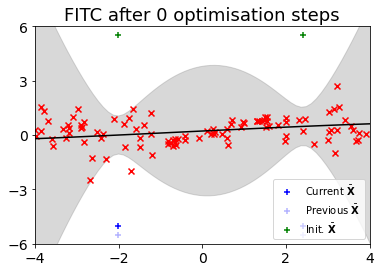

Step: 10000 Log evidence: -79.6820 Log coeff: -0.02 Log scales: [-0.019] Log noise: -2.56


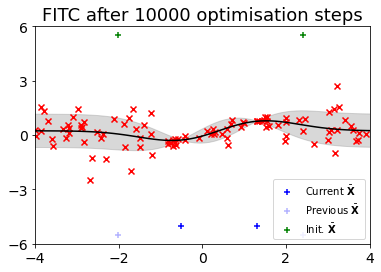

In [58]:
import tensorflow_probability as tfp

# Set random seed and tensor dtype
tf.random.set_seed(1)
dtype = tf.float64

# Number of inducing points
M = 2
inducing_range = (-3., 3.)
log_noise = 0.
log_coeff = 1.
log_scales = [1.]
learn_rate = 1e-2
num_steps = int(1e4)

# Training data x_obs, y_obs are the data sampled from FITC from before
x_train, y_train = x_obs[:, 0], y_obs[:, 0]

# Initial locations of inducing points
x_ind_dist = tfp.distributions.Uniform(low=inducing_range[0], high=inducing_range[1])
x_ind_init = x_ind_dist.sample(sample_shape=(M, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

# Locations to visualise the
x_pred = tf.linspace(-6., 6., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=dtype)

mean = constant_mean(dtype=dtype)

cov = eq_covariance(log_coeff=log_coeff,
                    log_scales=log_scales,
                    dim=1,
                    dtype=dtype)

fitc_gp = FITCGP(mean=mean,
                 cov=cov,
                 log_noise=log_noise,
                 x_train=x_train[:, None],
                 y_train=y_train,
                 x_ind_init=x_ind_init,
                 dtype=dtype)

optimizer = tf.keras.optimizers.Adam(learn_rate)

x_ind_prev = x_ind_init[:, 0].numpy()


for step in range(num_steps + 1):
    
    if step % num_steps == 0:
        
        print_numbers(fitc_gp,
                      step)
        
        plot(fitc_gp,
             x_pred,
             x_train,
             y_train,
             x_ind_prev,
             x_ind_init,
             step)
    
    with tf.GradientTape() as tape:

        log_evidence = fitc_gp.log_lik()
        loss = - log_evidence

    gradients = tape.gradient(loss, fitc_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, fitc_gp.trainable_variables))

## Conclusion

### Summary

FITC is a sparse model which can be scaled to larger datasets. It achieves scalability by introducing $M$ *inducing points* and assuming an independence between the observations given the outputs of the inducing points. Due to this independence, FITC enjoys $\mathcal(O)(NM^2)$ complexity when evaluating the evidence or making predictions, allowing it to scale to larger datasets.

### Issues and observations

- FITC is a different model from the simple GP we started with. The modelling assumptions are simply different from the original GP. So, if we are looking for a tractable method that is still faithful to the original GP, FITC may not be a great choice. That being said, maybe FITC is a model we should have considered in the first place, as a candidate for modelling the data. The suitability of different models can be quantified by evaluating the marginal likelihood - if FITC is more likely than a vanilla GP, given the data, then we should use that!

- Although FITC can be used as a cheap and easy way to model data with an input-dependent noise level, it's generative assumptions tie the mean and error bars in an unusual way. In particular, the model cannot get more uncertain without the mean decaying back to the prior mean. In regions where the data has a large mean and large noise level simulateneously, FITC would have trouble.

In [ ]:
def plot(model, title=""):
    
    x_pred = tf.linspace(-6., 6., 100)[:, None]
    x_pred = tf.cast(x_pred, dtype=tf.float64)

    mean, var = model.predict_y(x_pred)

    x_pred_ = x_pred[:, 0].numpy()
    mean_ = mean[:, 0].numpy()
    var_ = var[:, 0].numpy()

    x_ind_curr = model.inducing_variable.Z.numpy()

    plt.plot(x_pred_, mean_, color='black')
    plt.fill_between(x_pred_,
                     mean_ - var_ ** 0.5,
                     mean_ + var_ ** 0.5,
                     color='gray',
                     alpha=0.3)

    plt.scatter(x_train, y_train, color='red', marker='x')
    plt.scatter(x_ind_curr, -1.5 * tf.ones_like(x_ind_curr), color='blue', marker='+')
    plt.ylim([-2, 2])
    plt.show()

Before optimisation
<tf.Variable 'Pow/mul/Variable:0' shape=(10, 1) dtype=float64, numpy=
array([[-3.        ],
       [-2.33333325],
       [-1.66666663],
       [-1.        ],
       [-0.33333325],
       [ 0.33333349],
       [ 1.        ],
       [ 1.66666698],
       [ 2.33333349],
       [ 3.        ]])>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=-4.600266525158521>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
0 tf.Tensor(-613.4539470918894, shape=(), dtype=float64)


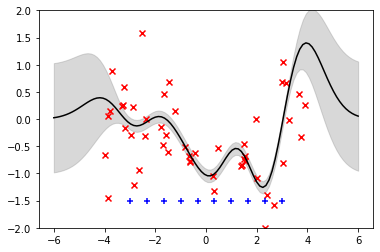

500 tf.Tensor(-59.921398748788825, shape=(), dtype=float64)


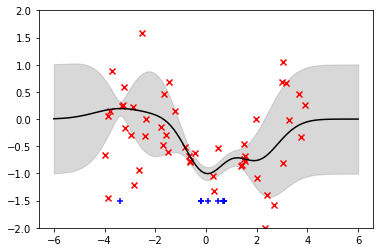

1000 tf.Tensor(-59.813392799390805, shape=(), dtype=float64)


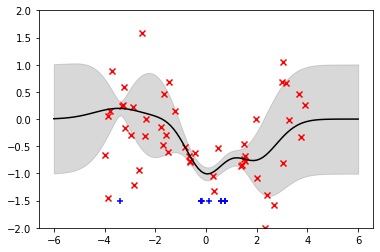

1500 tf.Tensor(-59.80665555230898, shape=(), dtype=float64)


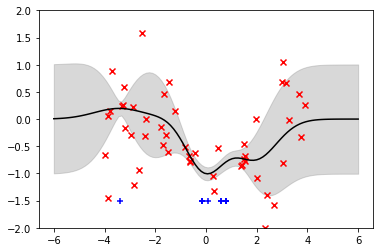

2000 tf.Tensor(-59.80065949319633, shape=(), dtype=float64)


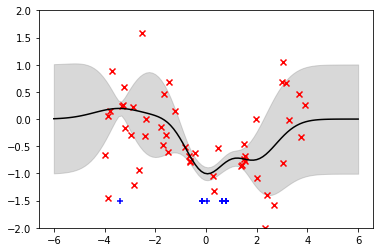

2500 tf.Tensor(-59.78588034691213, shape=(), dtype=float64)


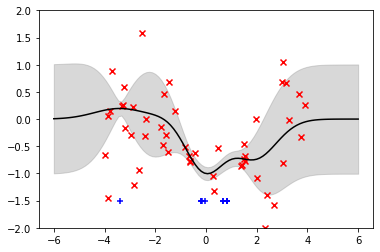

3000 tf.Tensor(-59.68516264797949, shape=(), dtype=float64)


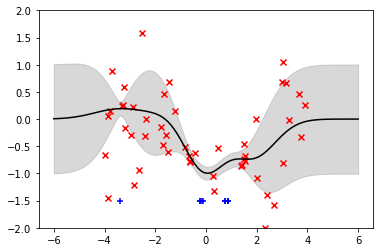

3500 tf.Tensor(-78.13200919642566, shape=(), dtype=float64)


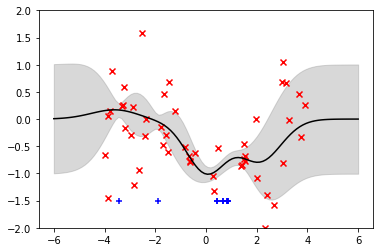

4000 tf.Tensor(-66.63021115391462, shape=(), dtype=float64)


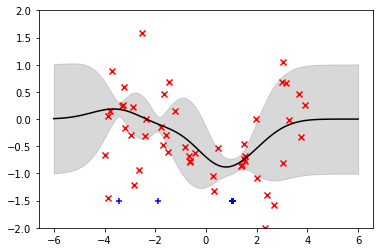

4500 tf.Tensor(-66.63709985751825, shape=(), dtype=float64)


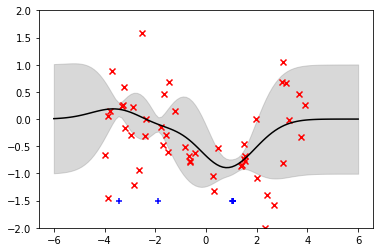

5000 tf.Tensor(-66.63710620253367, shape=(), dtype=float64)


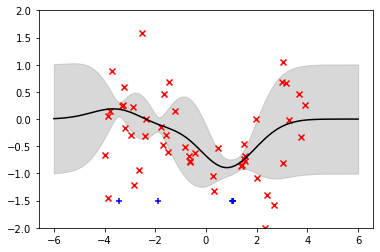

5500 tf.Tensor(-66.63710621845378, shape=(), dtype=float64)


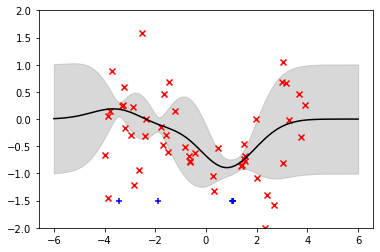

6000 tf.Tensor(-66.63710621849663, shape=(), dtype=float64)


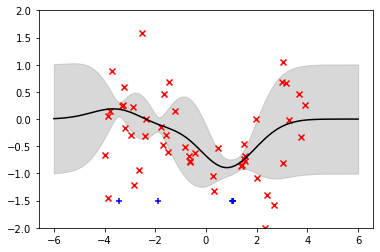

6500 tf.Tensor(-66.6371062185412, shape=(), dtype=float64)


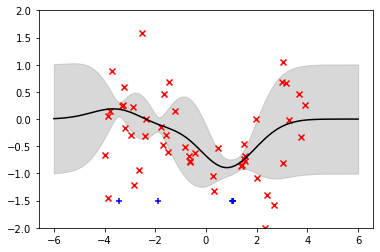

7000 tf.Tensor(-66.63710621849529, shape=(), dtype=float64)


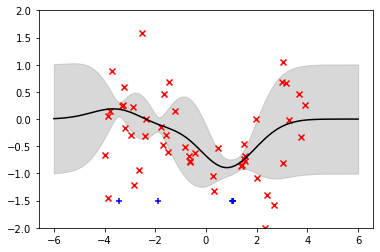

7500 tf.Tensor(-66.63710621855148, shape=(), dtype=float64)


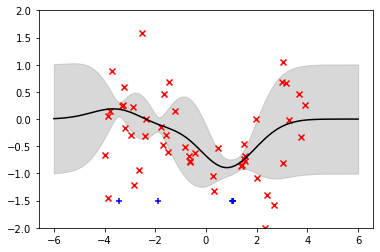

8000 tf.Tensor(-66.63710621850706, shape=(), dtype=float64)


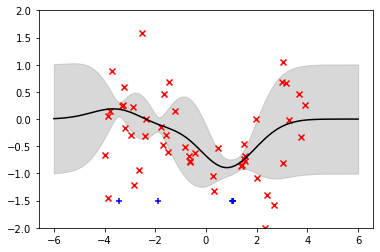

8500 tf.Tensor(-66.6371062184906, shape=(), dtype=float64)


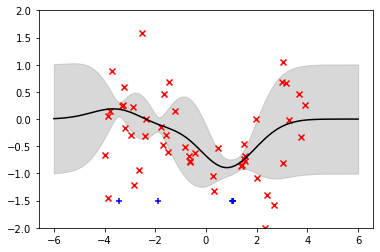

9000 tf.Tensor(-66.6371062184997, shape=(), dtype=float64)


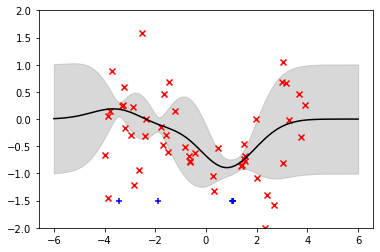

9500 tf.Tensor(-66.63710621847164, shape=(), dtype=float64)


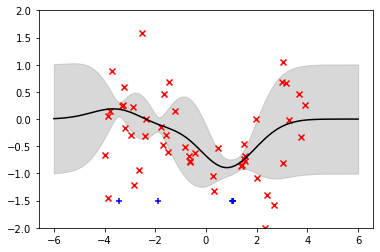

10000 tf.Tensor(-66.63710621850845, shape=(), dtype=float64)


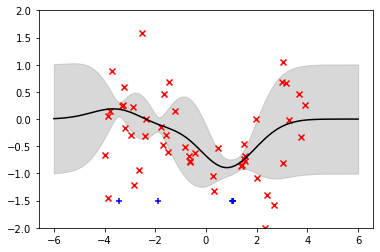

After optimisation
<tf.Variable 'Pow/mul/Variable:0' shape=(10, 1) dtype=float64, numpy=
array([[-3.42186804],
       [ 1.07563989],
       [-1.87487721],
       [ 1.0568379 ],
       [ 1.03793191],
       [ 1.0568379 ],
       [ 1.0568379 ],
       [ 1.0568379 ],
       [ 1.0568379 ],
       [ 1.0568379 ]])>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=-4.600266525158521>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Pow/mul/Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>


In [442]:
dtype = tf.float64

num_inducing = 10
inducing_range = (-3., 3.)

x_train, y_train = x_obs[:, 0], y_obs[:, 0] # get_gp_train_data(num_datapoints=10)

tf.random.set_seed(0)
x_ind_init = tf.linspace(inducing_range[0], inducing_range[1], num_inducing)[:, None]
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

x_pred = tf.linspace(-6., 6., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=dtype)

kernel = gpf.kernels.SquaredExponential(variance=1., lengthscales=1.)

fitc = gpf.models.GPRFITC([x_train[:, None],y_train[:, None]], 
                          kernel=kernel, 
                          inducing_variable=x_ind_init,
                          noise_variance=1e-2)

print('Before optimisation')
for var in fitc.trainable_variables: print(var)
for var in kernel.trainable_variables: print(var)

optimizer = tf.optimizers.SGD(learning_rate=1e-3)
    
def optimization_step(model):
    
    with tf.GradientTape() as tape:

        log_evidence = model.maximum_log_likelihood_objective()
        loss = - log_evidence

    gradients = tape.gradient(loss, fitc.trainable_variables[:1])
    optimizer.apply_gradients(zip(gradients, fitc.trainable_variables[:1]))

    return log_evidence
    
    
for step in range(10001):
    
    if step % 500 == 0:
        log_evidence = fitc.fitc_log_marginal_likelihood()
        print(step, log_evidence)
        plot(fitc)
        
    log_evidence = optimization_step(fitc)
    
print('After optimisation')
for var in fitc.trainable_variables: print(var)
for var in kernel.trainable_variables: print(var)

In [1]:
def get_sine_train_data():

    num_datapoints = 50
    noise = 1e-1

    x = np.random.uniform(low=-np.pi, high=np.pi, size=(num_datapoints,))
    y = np.sin(x) + np.random.normal(loc=0., scale=noise, size=(num_datapoints,))
    
    return x, y
    

x, y = get_sine_train_data()

plt.scatter(x, y)
plt.show()

NameError: name 'np' is not defined

In [ ]:
def get_gp_train_data(num_datapoints):
    
    tf.random.set_seed(0)
    np.random.seed(0)
    
    log_coeff = 0.
    log_noise = -1.
    log_scales = [0.]
    
    x = np.random.uniform(low=-np.pi, high=np.pi, size=(num_datapoints,))
    x = x[:, None]

    mean = zero_mean(dtype=dtype)
    mean = mean(x)

    cov = eq_covariance(log_coeff=log_coeff,
                        log_scales=log_scales,
                        dim=1,
                        dtype=dtype)
    cov = cov(x, x)
    cov = cov + tf.cast((10 ** log_noise) ** 2, dtype=tf.float64) * tf.eye(cov.shape[0], dtype=tf.float64)

    normal = tfp.distributions.MultivariateNormalTriL
    normal = normal(loc=mean, scale_tril=tf.linalg.cholesky(cov))
    
    y = normal.sample()
    
    return x[:, 0], y
    

x, y = get_gp_train_data(num_datapoints=100)

plt.scatter(x, y)
plt.show()

In [ ]:
x_train, y_train = get_gp_train_data(num_datapoints=100)

x_train = tf.convert_to_tensor(x_train, dtype=tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)

x_pred = tf.linspace(-3., 3., 100)
x_pred = tf.cast(x_pred, dtype=tf.float64)

cov = eq_covariance(log_coeff=0.,
                    log_scales=0.,
                    dim=1,
                    dtype=dtype)

K_xX = cov(x_pred[:, None], x_train[:, None])
K_Xx = cov(x_train[:, None], x_pred[:, None])
K_XX = cov(x_train[:, None], x_train[:, None], epsilon=1e-6)

X_XX_plus_noise = K_XX + 1e-2 * tf.eye(K_XX.shape[0], dtype = tf.float64)

y_pred = tf.einsum('ij, jk -> ik',
                   K_xX,
                   tf.linalg.solve(X_XX_plus_noise, y_train[:, None]))

plt.plot(x_pred, y_pred)
plt.scatter(x_train, y_train)